In [1]:
%matplotlib inline

In [2]:
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
from helper.common_imports import *

# 1. load dataset


In [5]:
datafolder = './dataset/'
df = pd.read_csv(datafolder+'dataset.pd', index_col=0)

In [6]:
df.head()

,user,surface,finger,class,filename,time
0,user_0,S3,index,touch,0.hdf5,2017-03-08_10:48:36
1,user_0,S3,index,notouch,1.hdf5,2017-03-08_10:50:27
2,user_0,S3,thumb,touch,2.hdf5,2017-03-08_10:52:53
3,user_0,S3,thumb,notouch,3.hdf5,2017-03-08_10:54:12
4,user_0,S3,pinky,touch,4.hdf5,2017-03-08_10:55:51


# test classification of images

A naive approach would be to throw the depth images directly at a classifier and see what kind of performance we could get.

In [8]:
frames = []

In [9]:
for i, row in df.iloc[:4].iterrows():
    with h5py.File(datafolder+row['filename'], 'r') as hf:
        frames.append(hf['data/depth'][:])

In [10]:
frames = np.array(frames)

In [11]:
frames = frames.reshape((4, 900, -1))

In [12]:
y = np.tile(np.r_[np.ones(900), np.zeros(900)], 2).reshape(4, 900)

In [13]:
frames.shape

(4, 900, 307200)

# compare different classifier sklearn

In [14]:
Xc = frames

In [15]:
train_id = [0,1]
test_id = [2,3]

X_train = np.r_[tuple([Xc[i] for i in train_id])]
X_test  = np.r_[tuple([Xc[i] for i in test_id])]

y_train = y[train_id].reshape(-1)
y_test  = y[test_id].reshape(-1)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [17]:
# clf = DecisionTreeClassifier(max_depth=5)
# clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
# clf = MLPClassifier(alpha=1, max_iter=1000)

In [ ]:
%%time
clf.fit(X_train, y_train)

In [ ]:
%%time
clf.score(X_test, y_test)

<table>
<tr>
<th>classifier</th>
<th>score</th>
</tr>
<tr>
<td>DecisionTreeClassifier</td>
<td>0.85</td>
</tr>
</table>
RandomForestClassifier
0.60

MLPClassifier
0.82

AdaBoostClassifier
0.865

In [29]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()]

In [ ]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(name, score)

# 2. extract the features

This notebook relies on feature extractions for creating vectors that can be fed into a classifier.
The processing includes several steps:

- Deproject: depth image are turned into pointcloud
- VoxelGridFilter: resolution is decreased to speed up processing
- RoiExtractor: closest point to the camera is identified
- FingerPlaneExtractor: finger and plane are separated
- FeatureExtractor: histogram of finger is computed

The result is the histogram of z-values of the user pointer.

In [7]:
from helper import processing_pcl as ps

In [8]:
ps.pip

Pipeline(memory=None,
         steps=[('deproject', Deproject()),
                ('voxelgridfilter', VoxelGridFilter(leaf_size=0.002)),
                ('roiextractor', RoiExtractor()),
                ('fingerPlaneExtractor', FingerPlaneExtractor()),
                ('featureextractor', FeatureExtractor())],
         verbose=True)

In [9]:
%%time
from multiprocessing import Pool
pool = Pool(processes=8)
Xc = pool.map(ps.extract_feature, df.iterrows())

classification 0:01:11.361531 for 900 frames
classification 0:01:12.568883 for 900 frames
classification 0:01:18.178064 for 900 frames
classification 0:01:18.481897 for 900 frames
classification 0:01:20.187032 for 900 frames
classification 0:01:21.429817 for 900 frames
classification 0:01:24.458393 for 900 frames
classification 0:01:26.571984 for 900 frames
classification 0:00:56.751115 for 900 frames
classification 0:01:03.225828 for 900 frames
classification 0:00:58.382707 for 900 frames
classification 0:00:59.295098 for 900 frames
CPU times: user 143 ms, sys: 84.5 ms, total: 227 ms
Wall time: 2min 17s


In [8]:
Xc = np.array(Xc)

# 3. compare with features.npy
The original features are saved under the dataset folder. These can be compared against features produced with other parameters set for example.

In [9]:
Xc_ref = np.load('./dataset/features.npy')

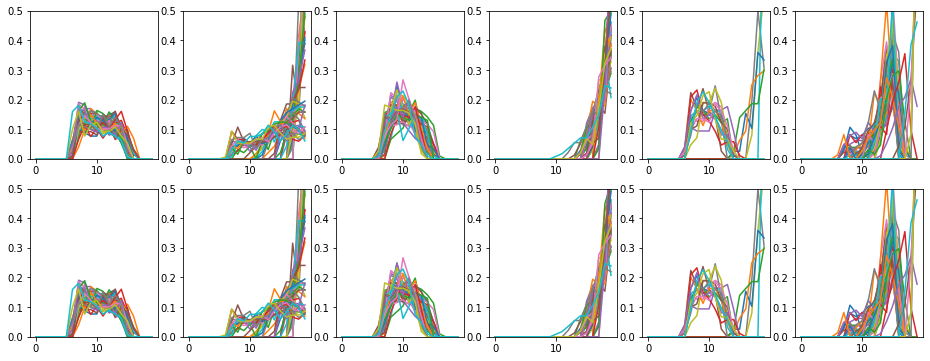

In [19]:
fig, axs = plt.subplots(2,6, figsize=(16, 6))

for i, feature in enumerate([Xc_ref, Xc]):
    for j in range(6):
        axs[i,j].plot(feature[j,:50].T)
        axs[i,j].set_ylim([0,0.5])

In [16]:
np.count_nonzero(np.isclose(Xc_ref, Xc)) / np.prod(Xc.shape)

0.9987314814814815

# 4. classify
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [20]:
from sklearn.model_selection import KFold
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

Using TensorFlow backend.


In [21]:
y = np.tile(np.r_[np.ones(900), np.zeros(900)], 6).reshape(12, 900)

In [23]:
train_id = [0,1]
test_id = [2,3,4,5,6,7,8,9,10,11]

x_train = np.r_[tuple([Xc[i] for i in train_id])]
x_test  = np.r_[tuple([Xc[i] for i in test_id])]

y_train = y[train_id].reshape(-1) #np.r_[tuple([y[i] for i in train_id])]
y_test  = y[test_id].reshape(-1) #np.r_[tuple([y[i] for i in test_id])]

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(64, input_dim=20, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1344      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(x_train, y_train, validation_split=0.3, epochs=1000, batch_size=1000, verbose=0)

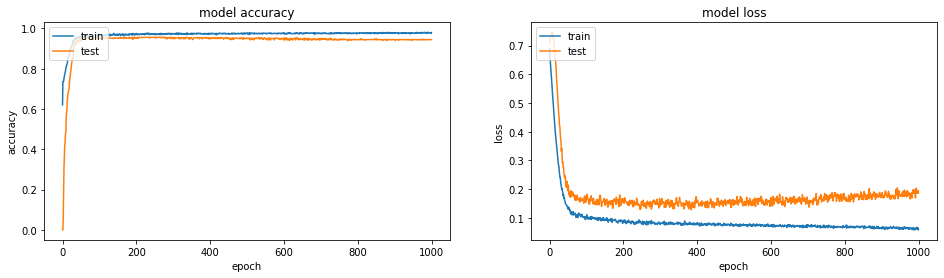

In [35]:
fig, axs = plt.subplots(1,2, figsize=(16,4))
# summarize history for accuracy
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
_=axs[1].legend(['train', 'test'], loc='upper left')

# K-fold validation

In [36]:
def split_data(train, test):
    train_id = train
    test_id = test

    x_train = np.r_[tuple([Xc[i] for i in train_id])]
    x_test  = np.r_[tuple([Xc[i] for i in test_id])]

    y_train = y[train_id].reshape(-1)
    y_test  = y[test_id].reshape(-1)
    
    return x_train, x_test, y_train, y_test

In [37]:
def get_model():
    model = Sequential()
    model.add(Dense(64, input_dim=20, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [38]:
n_dataset = len(Xc)
n_splits = 3

kf = KFold(n_splits = n_splits)
for train, test in kf.split(range(n_dataset)):
    print("%s %s" % (train, test))

[ 4  5  6  7  8  9 10 11] [0 1 2 3]
[ 0  1  2  3  8  9 10 11] [4 5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10 11]


In [40]:
import seaborn as sns

In [1]:
from multiprocessing import Array

[ 4  5  6  7  8  9 10 11] [0 1 2 3]
[ 0  1  2  3  8  9 10 11] [4 5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10 11]


(-0.1, 1.1)

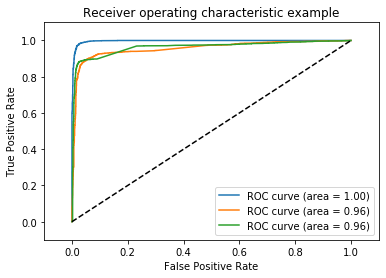

In [41]:
from sklearn.model_selection import KFold

    
fig, ax = plt.subplots()


n_dataset = len(Xc)
n_splits = 3

fprs = []
tprs = []
thrs = []

kf = KFold(n_splits = n_splits)
for train, test in kf.split(range(n_dataset)):
    print("%s %s" % (train, test))
    
    x_train, x_test, y_train, y_test = split_data(train, test)
    
    model = get_model()
    history = model.fit(x_train, y_train, validation_split=0.3, epochs=200, batch_size=1000, verbose=0)
    y_pred = model.predict(x_test)
    
    fpr, tpr, thr = metrics.roc_curve(y_test, y_pred)
    
    fprs.append(fpr)
    tprs.append(tpr)
    thrs.append(thr)

    roc_auc = metrics.auc(fpr, tpr)

    metrics_classification_report = metrics.classification_report(y_test, np.round(y_pred))
#     print metrics.classification_report(y_test, np.round(y_pred))

    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")    
ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='Luck')

ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])

(-0.1, 1.1)

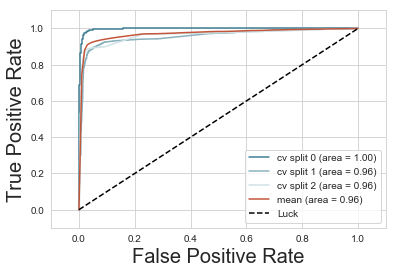

In [22]:
from scipy import interp

# sns.set_style("ticks")
sns.set_style("whitegrid")
fig, ax = plt.subplots()

colors = sns.cubehelix_palette(4)
colors = sns.diverging_palette(220, 20, n=6)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
 

for i in range(n_splits):
    fpr, tpr = fprs[i], tprs[i]
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label='cv split %d (area = %0.2f)' % (i, roc_auc), color=colors[i])

    mean_tpr += interp(mean_fpr, fpr, tpr)

mean_tpr[0] = 0.0
mean_tpr /= n_splits
mean_tpr[-1] = 1.0

ax.plot(mean_fpr, mean_tpr, label='mean (area = %0.2f)' % roc_auc, color=colors[-1])
ax.plot([0, 1], [0, 1], color='k', label='Chance', linestyle='--')

    
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
# ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")    
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
